<a href="https://colab.research.google.com/github/danisJIOGUE/statistics-application/blob/master/predict_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default risk rating in non profit microfinance : case of non profit orgnisation KIVA

The main purpose of this study is to predict the defaut risk of the client of the **non profit organisation Kiva**. To archieve this goal we will use some predictions models to find the score of each lender. The following step will be use to build our models :
# I) Explonatory data analysis
### a) Merge the dataset
### b) Univariate analysis
### c) Bivariate analysis
### d) Multivariate analysis
# II) Modelisation
### a) Resampling our dataset
### b) Selection of the variable
### c) Implementation

# Explonatory data analysis
As define previously, we will first start to merging our datasets. Before doing this we will install all the libraries.
### a) Merge the dataset

In [4]:
#!pip install pycountry_convert
#!pip install langdetect
#!pip install nltk
#!pip install Wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from subprocess import check_output
from plotnine import *
from google.colab import drive
from sklearn.impute import KNNImputer
import pycountry_convert as pc
drive.mount('/content/drive')



from langdetect import detect

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from wordcloud import WordCloud

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 Now we have install the librabries, We will upload our datasets. We have two datasets :
> - Loan dataset : contain some basics information in the lender
- Description dataset : contain the informations which are related to the description of each loan.

In [5]:
#Detection of the dataset'encoding
import chardet

#Loan dataset
with open("/content/drive/My Drive/Stat_App/loans.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.7291077209623456, 'encoding': 'ISO-8859-1', 'language': ''}

In [6]:
loan = pd.read_csv('/content/drive/My Drive/Stat_App/loans.csv', encoding ='ISO-8859-1',  sep=";")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,4,11,30,32,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#Description dataset
with open("/content/drive/My Drive/Stat_App/description.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [8]:
db_desc = pd.read_csv('/content/drive/My Drive/Stat_App/description.csv', encoding ='utf-8',  sep=";")

In [9]:
print('The shape (nb obs ; nb var) of the data set : \n\n loan :', loan.shape,'\n description : ', db_desc.shape)

The shape (nb obs ; nb var) of the data set : 

 loan : (42181, 42) 
 description :  (3182, 19)


In [10]:
db_desc.head(2)

,id,loan_name,description,description_translated,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,partner_id,lender_term,num_lenders_total,tags,borrower_names,borrower_genders,borrower_pictured,repayment_interval,distribution_model
0,156,Marks Antonio,Through my association with the local elementa...,NaN,Purchase of tools and materials to full first ...,NI,Nicaragua,Managua,standard,NaN,5,6,1,NaN,Marks Antonio,male,true,monthly,field_partner
1,173,NaN,NaN,NaN,NaN,GZ,Gaza,NaN,standard,NaN,2,12,7,user_favorite,NaN,NaN,NaN,monthly,field_partner


In [11]:
loan.head(2)

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,362.0,50,05/06/2006,50,16/09/2006,12.150833,-86.268333


Now have have the quick look of our datasets, we are going to start the pretraitement for the dataset **loans** which contain many duplicates observations.
* Drop dupplicates observations

In [12]:
## Number of dupplicates values (loan database)
loan.duplicated(subset=['id']).sum()

37177

In [13]:
#create variable dupplicates which gives the status of each id
loan.id.duplicated().value_counts()

True     37177
False     5004
Name: id, dtype: int64

In [14]:
#Database without dupplicates values
data = loan.drop_duplicates(subset='id')
data.reset_index(inplace=True)
data = data.drop('index',axis=1)
data.head(2)

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,173,en,defaulted,600,NaN,Construction,Construction,NaN,Gaza,Rafah,town,2,Mansour,Al Nawajha,M,True,600,USD,14/04/2005,600.0,lender,none,15/02/2006,31/03/2005,7.0,11/09/2007,11/09/2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,261.0,50,27/04/2006,50,NaN,31.284167,34.250833


In [15]:
print('The shape of our new dataset without duplicates : ', data.shape)

The shape of our new dataset without duplicates :  (5004, 42)


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5004 entries, 0 to 5003
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      5004 non-null   object 
 1   description.languages                   3267 non-null   object 
 2   status                                  5004 non-null   object 
 3   funded_amount                           5004 non-null   object 
 4   paid_amount                             4904 non-null   object 
 5   activity                                5004 non-null   object 
 6   sector                                  5004 non-null   object 
 7   location.country_code                   4962 non-null   object 
 8   location.country                        5004 non-null   object 
 9   location.town                           4871 non-null   object 
 10  location.geo.level                      5002 non-null   obje

This caption show that our loan dataset contains many variables which have no observations. These variables will be removed in our dataset, we are going keep only those which have the information.

In [17]:
#list of unuseful variables
useless = ['description.languages','activity','partner_id','location.geo.level','location.town','location.country_code',"borrowers.first_name",'borrowers.last_name',"video.youtube_id"]

In [18]:
data = data.drop(useless, axis = 1)
data.shape

(5004, 33)

In [19]:
data.head(2)

,id,status,funded_amount,paid_amount,sector,location.country,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,paid,500,500,Construction,Nicaragua,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,173,defaulted,600,NaN,Construction,Gaza,M,True,600,USD,14/04/2005,600.0,lender,none,15/02/2006,31/03/2005,7.0,11/09/2007,11/09/2007,NaN,NaN,NaN,NaN,NaN,NaN,50.0,261.0,50,27/04/2006,50,NaN,31.284167,34.250833


* Merge dataset laon with description

*These* datasets do not have the same size we are going to merge them.

In [20]:
resul = pd.merge(data, db_desc, how = 'left', on = ['id','id'])

In [21]:
resul.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'sector',
       'location.country', 'borrowers.gender', 'borrowers.pictured',
       'terms.disbursal_amount', 'terms.disbursal_currency',
       'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'loan_name', 'description', 'description_translated', 'loan_use',
       'country_code', 'country_name', 'town_name', 'currency_policy',
       'currency_exchange_coverage_rate', 'partner_id', 'lender_term',
       'num_lenders_total', 'tags', 'borrow

After merging our datasets, we are now going to look for the missing values. This analysis will help us to see whether it is good or not to merge the dataset.

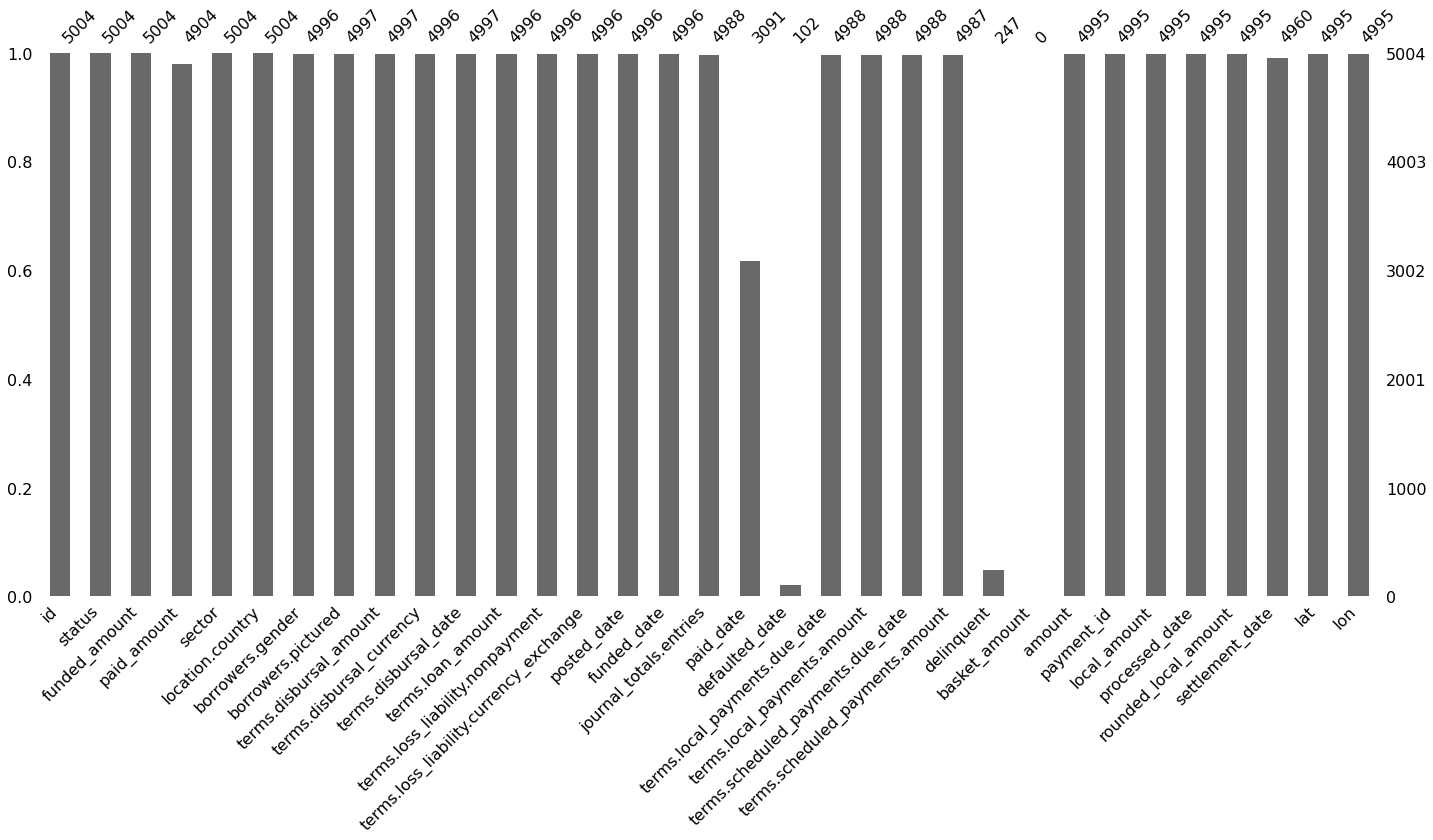

In [22]:
# Missing value of the loan dataset
msno.bar(data)

With thses above graphics, we see that the merging dataset has many missing values. Indeed, the description dataset contribute to reduce the information which are contained in the loan dataset. So, we will use only the loan dataset.

### b) Univariate analysis
In this part we will find out the information behind the variables.
* **Qualitative variable**
  * Loan Status

In [23]:
pd.crosstab(data.status,"freq")

col_0,freq
status,
101,1
F,1
defaulted,100
in_repayment,1818
paid,3084


In [24]:
data.status.unique()

array(['paid', 'defaulted', 'in_repayment', '101', 'F'], dtype=object)

In [25]:
#Drop modality '101' and 'F'
data = data[data.status != '101']
data = data[data.status != 'F']
data = data[data.status != 'in_repayment']
data.shape
conditions = [
    (data.status == 'defaulted'),
    (data.status == 'paid')
]
values = [1,0]

data['target'] = np.select(conditions, values)
pd.crosstab(data.target,"freq")

col_0,freq
target,
0,3084
1,100


* Sector

In [26]:
pd.crosstab(data['sector'],'freq').apply(lambda r: 100 * r/len(data), axis=1).round(2)

col_0,freq
sector,
Agriculture,17.02
Arts,3.11
Clothing,8.79
Construction,2.42
Education,0.13
Entertainment,0.09
Food,30.50
Health,0.94
Housing,0.82


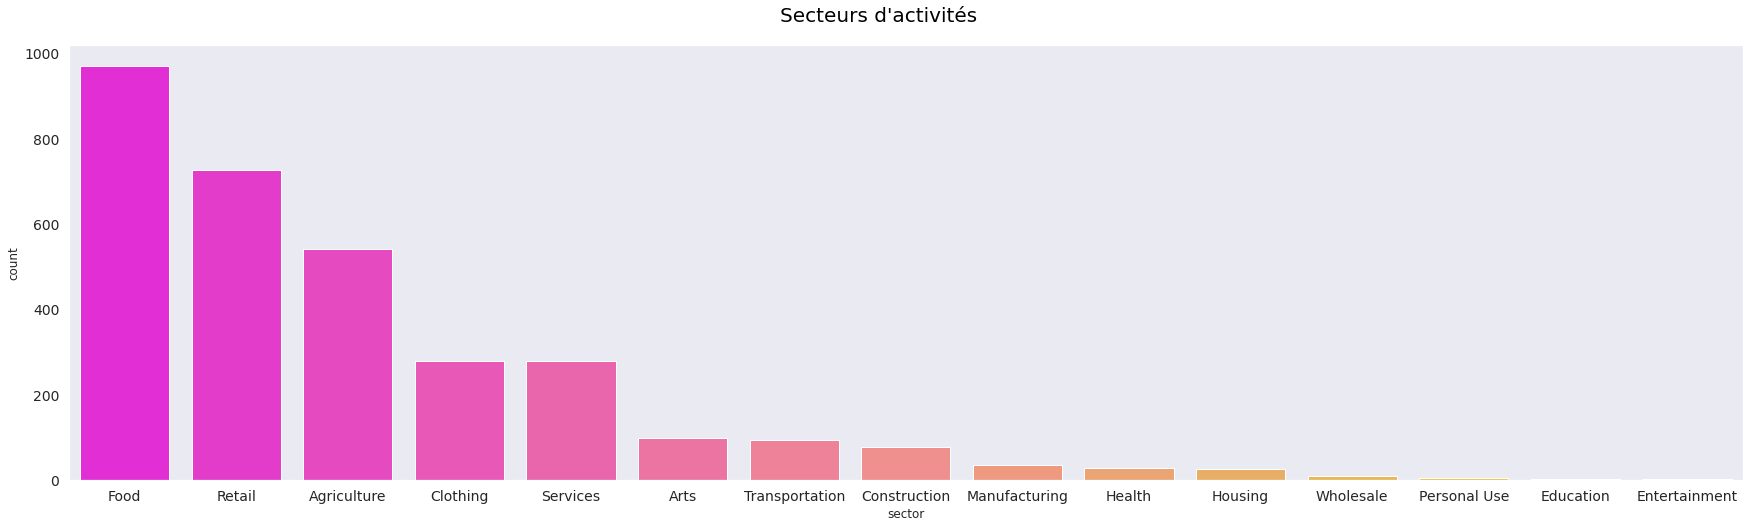

In [27]:
plt.figure(figsize=(30,8))
sns.set(rc={"axes.grid":False,'xtick.labelsize':14,'ytick.labelsize':14})
plt.gcf().text(.5, .93, "Secteurs d'activités", fontsize = 20, color='black' ,ha='center', va='center')
ax = sns.countplot(x=data['sector'] , order =data['sector'].value_counts().index , palette="spring")

plt.show()

In [28]:
Bien_Menage = ['Clothing','Housing','Personnal Use']
autre_secteur = ['Services','Education','Transportation','Arts','Health','Construction','Manufacturing','Entertainment','Wholesale']
conditions = [
    (data.sector == 'Agriculture'),
    (data.sector == 'Food'),
    (data.sector == 'Retail'),
    (data.sector == 'Clothing') | (data.sector == 'Housing') | (data.sector == 'Personal Use'),
    (data.sector == 'Services') | (data.sector == 'Education') | (data.sector == 'Transportation') | (data.sector == 'Arts') | (data.sector == 'Health') | (data.sector == 'Services') | (data.sector == 'Construction') |  (data.sector == 'Manufacturing') | (data.sector == 'Entertainment') | (data.sector == 'Wholesale')
]
values = ['Agriculture','Food','Retail','Bien_Menage','autre_secteur']
data.sector = np.select(conditions, values)

pd.crosstab(data['sector'],'freq').apply(lambda r: 100 * r/len(data), axis=1).round(2)

col_0,freq
sector,
Agriculture,17.02
Bien_Menage,9.80
Food,30.50
Retail,22.83
autre_secteur,19.85


* Borrower gender

In [29]:
# Unique modalité of this variable
data.rename(columns={'borrowers.gender':'gender'}, inplace = True)
len(pd.unique(data['gender']))

pd.crosstab(data['gender'].isna(),'freq')

col_0,freq
gender,
False,3181
True,3


We have 3 borrowers who do not give the gender.

In [30]:
# Suppression des missings values
data = data.dropna(how='all', subset=['gender'])

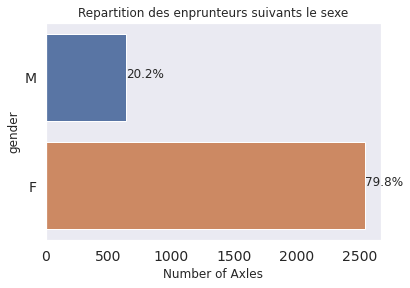

In [31]:
ax = sns.countplot(y="gender", data=data)
plt.title('Repartition des enprunteurs suivants le sexe')
plt.xlabel('Number of Axles')

total = len(data['gender'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Countries repartition

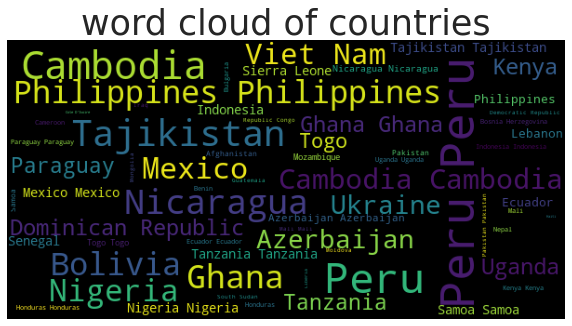

In [32]:
# Wordcloud of the country
data.rename(columns={'location.country':'country_name'}, inplace = True)

names = data["country_name"][~pd.isnull(data["country_name"])]
#print(names)
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(names))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.title("word cloud of countries", fontsize=35)
plt.axis("off")
plt.show() 

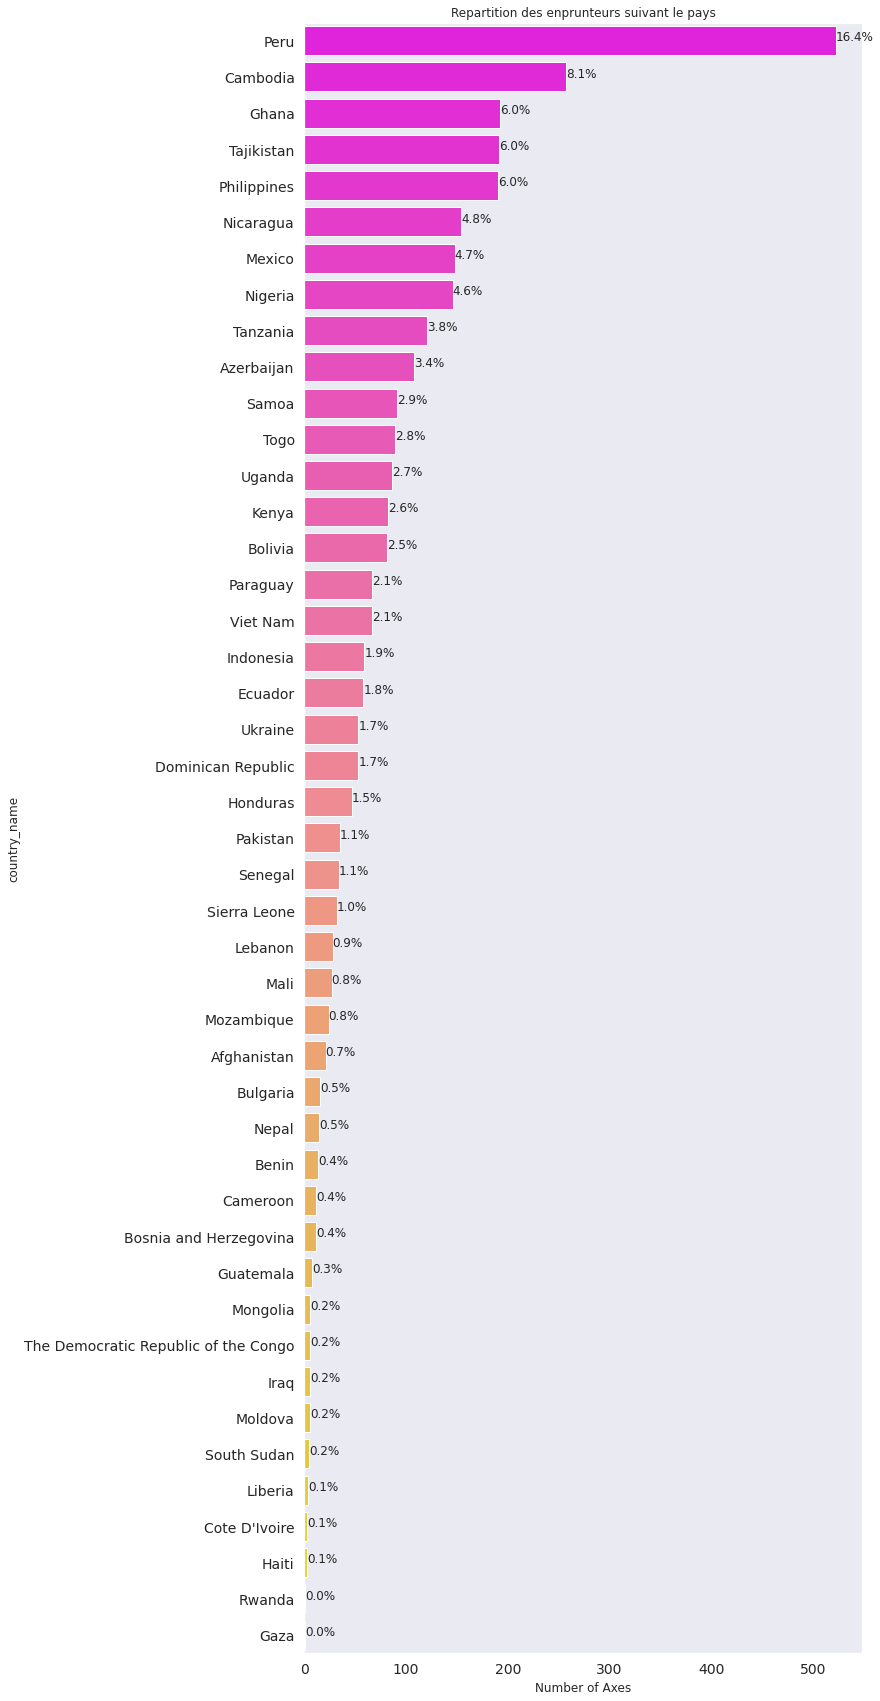

In [33]:
plt.figure(figsize=(10,30))
ax = sns.countplot(y="country_name", data=data, order =data['country_name'].value_counts().index , palette="spring")
#ax = sns.countplot(x=data['SECTOR_NAME'] )

plt.title('Repartition des enprunteurs suivant le pays')
plt.xlabel('Number of Axes')

total = len(data['country_name'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [34]:
# grouping the country due to their continent
def pays_par_continent(country_name):
    while True:
      try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
        break
      except KeyError:
        return 'Unknown'

data['CONTINENT'] = data['country_name'].apply(pays_par_continent)

#vérification du rendu :
data['CONTINENT'].unique()

array(['North America', 'Unknown', 'Africa', 'Europe', 'Asia', 'Oceania',
       'South America'], dtype=object)

In [35]:
# We have the modality Unknown which we are going to give the real value
# looking for the country correspond to unknow
data[data['CONTINENT']=='Unknown']['country_name'].unique()

array(['Gaza', 'The Democratic Republic of the Congo', "Cote D'Ivoire"],
      dtype=object)

In [36]:
data.CONTINENT = np.where((data.country_name == 'The Democratic Republic of the Congo') | (data.country_name == "Cote D'Ivoire"),'Africa',data.CONTINENT)
data.CONTINENT = np.where((data.country_name == 'Gaza'),'Asia',data.CONTINENT)

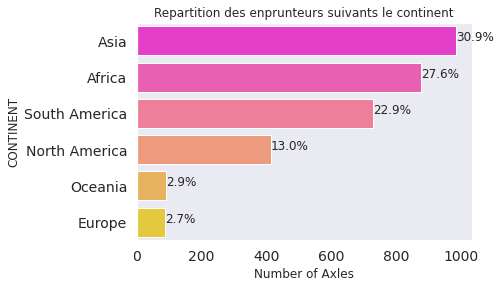

In [37]:
#plt.figure(figsize=(10,30))
ax = sns.countplot(y="CONTINENT", data=data, order =data['CONTINENT'].value_counts().index , palette="spring")
#ax = sns.countplot(x=data['SECTOR_NAME'] )

plt.title('Repartition des enprunteurs suivants le continent')
plt.xlabel('Number of Axles')

total = len(data['CONTINENT'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Borrower pictured

In [38]:
data.rename(columns={'borrowers.pictured':'borrower_pictured'}, inplace = True)

pd.crosstab(data['borrower_pictured'],'freq').apply(lambda r: 100 * r/len(data), axis=1)

col_0,freq
borrower_pictured,
True,49.984282
FALSE,0.094310
TRUE,49.921408


In [39]:
conditions = [
    (data.borrower_pictured == 'TRUE') | (data.borrower_pictured == 'True'),
    (data.borrower_pictured == 'FALSE')
]
values = ['TRUE','FALSE']

data['borrower_pictured'] = np.select(conditions, values)
pd.crosstab(data['borrower_pictured'],'freq')

col_0,freq
borrower_pictured,
0,1590
FALSE,3
TRUE,1588


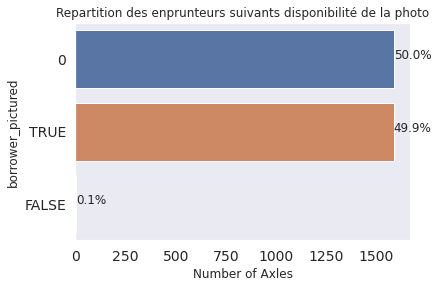

In [40]:
ax = sns.countplot(y="borrower_pictured", data=data)
plt.title('Repartition des enprunteurs suivants disponibilité de la photo')
plt.xlabel('Number of Axles')

total = len(data['borrower_pictured'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

* Date of payment (funded date, posted date)

In [41]:
data.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'sector',
       'country_name', 'gender', 'borrower_pictured', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'target', 'CONTINENT'],
      dtype='object')

In [42]:
# Conversion des variables en datetime

data["posted_date"] = pd.to_datetime(data["posted_date"])
data["funded_date"] = pd.to_datetime(data["funded_date"])
data["terms.disbursal_date"] = pd.to_datetime(data["terms.disbursal_date"])
data["settlement_date"] = pd.to_datetime(data["settlement_date"])

data["posted_date"].dt
data["funded_date"].dt
data["terms.disbursal_date"].dt
data["settlement_date"].dt

# Ajout des variables années à notre dataset
data["posted_date"] = data["posted_date"].dt.year
data["funded_date"] = data["funded_date"].dt.year
data["terms.disbursal_date"] = data["terms.disbursal_date"].dt.year
data["settlement_date"] = data["settlement_date"].dt.year

# Définition des variables pour la représentation graphique
df1 = pd.crosstab(data["posted_date"],"freq")
df2 = pd.crosstab(data["funded_date"],"freq")
df3 = pd.crosstab(data["terms.disbursal_date"],"freq")
df4 = pd.crosstab(data["settlement_date"],"freq")

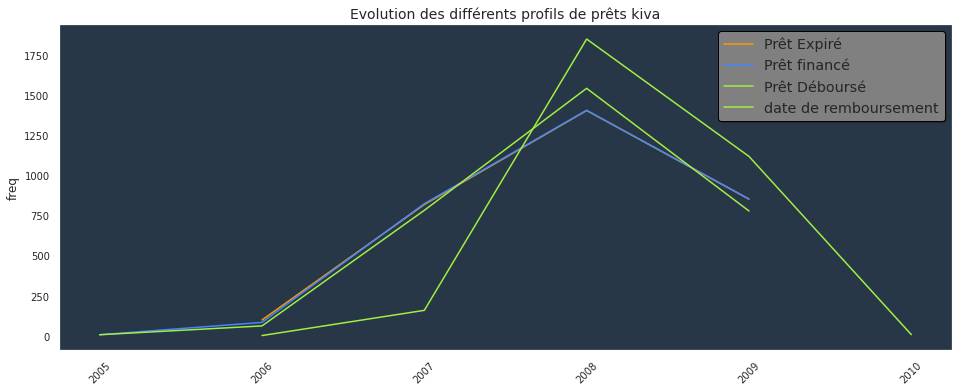

In [43]:
plt.figure(figsize=(16,6))
sns.set(rc={"axes.facecolor":"#283747", "axes.grid":False,'xtick.labelsize':10,'ytick.labelsize':10})
plt.title("Evolution des différents profils de prêts kiva",fontsize = 14)
plt.xticks(rotation=45) # Rotating X tickts by 45 degrees
sns.lineplot(x = df1.index.values, y = df1['freq'] , color = '#ff9900' , label= 'Prêt Expiré')
sns.lineplot(x = df2.index.values, y = df2['freq'] , color = '#4586ff' , label = 'Prêt financé')
sns.lineplot(x = df3.index.values, y = df3['freq'] , color = '#a2ef44' , label = 'Prêt Déboursé')
sns.lineplot(x = df4.index.values, y = df4['freq'] , color = '#a2ef44' , label = 'date de remboursement')
plt.legend(facecolor= 'grey' , fontsize='large' , edgecolor = 'black' ,shadow=True) # Legend formatting
plt.show()

* **Quantitative variable**

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181 entries, 0 to 5002
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3181 non-null   object 
 1   status                                  3181 non-null   object 
 2   funded_amount                           3181 non-null   object 
 3   paid_amount                             3081 non-null   object 
 4   sector                                  3181 non-null   object 
 5   country_name                            3181 non-null   object 
 6   gender                                  3181 non-null   object 
 7   borrower_pictured                       3181 non-null   object 
 8   terms.disbursal_amount                  3181 non-null   object 
 9   terms.disbursal_currency                3181 non-null   object 
 10  terms.disbursal_date                    3181 non-null   int6

In [45]:
data['funded_amount'] = pd.to_numeric(data['funded_amount'], downcast='float')
data['paid_amount'] = pd.to_numeric(data['paid_amount'], downcast='float')

In [46]:
numerical_col = data.select_dtypes(include =["number"]).columns.values
numerical_col

array(['funded_amount', 'paid_amount', 'terms.disbursal_date',
       'terms.loan_amount', 'posted_date', 'funded_date',
       'journal_totals.entries', 'basket_amount', 'amount', 'payment_id',
       'settlement_date', 'lat', 'lon', 'target'], dtype=object)

In [47]:
def Num_info(df, numeric_column):
  """ Fonction qui affiche les infos sur les variables quantitatives
    le nombre de missings et leur pourcentage """
  df_result = pd.DataFrame(columns=["columns","null_values","null_percent"])
    
  df_temp=pd.DataFrame()
  for value in numeric_column:

    df_temp["columns"] = [value]
    df_temp["null_values"] = df[value].isna().sum()
    df_temp["null_percent"] = (df[value].isna().sum()/len(df)*100).round(1)
    df_result = df_result.append(df_temp)
    
  df_result.sort_values("null_values", ascending =False, inplace=True)
  df_result.set_index("columns", inplace=True)
  return df_result

In [48]:
df_num = Num_info(data,numerical_col)
df_num

,null_values,null_percent
columns,,
basket_amount,3181,100.0
paid_amount,100,3.1
settlement_date,35,1.1
funded_amount,0,0.0
terms.disbursal_date,0,0.0
terms.loan_amount,0,0.0
posted_date,0,0.0
funded_date,0,0.0
journal_totals.entries,0,0.0


In [49]:
var_quanti = ['amount','paid_amount','funded_amount','journal_totals.entries']
data[var_quanti].describe()

,amount,paid_amount,funded_amount,journal_totals.entries
count,3181.000000,3081.000000,3181.000000,3181.000000
mean,107.415929,681.986389,680.084900,1.454574
std,142.532848,600.016907,593.962952,0.672619
min,0.080000,25.000000,25.000000,1.000000
25%,42.000000,325.000000,325.000000,1.000000
50%,69.000000,525.000000,525.000000,1.000000
75%,110.000000,900.000000,900.000000,2.000000
max,1818.100000,5000.000000,5000.000000,7.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

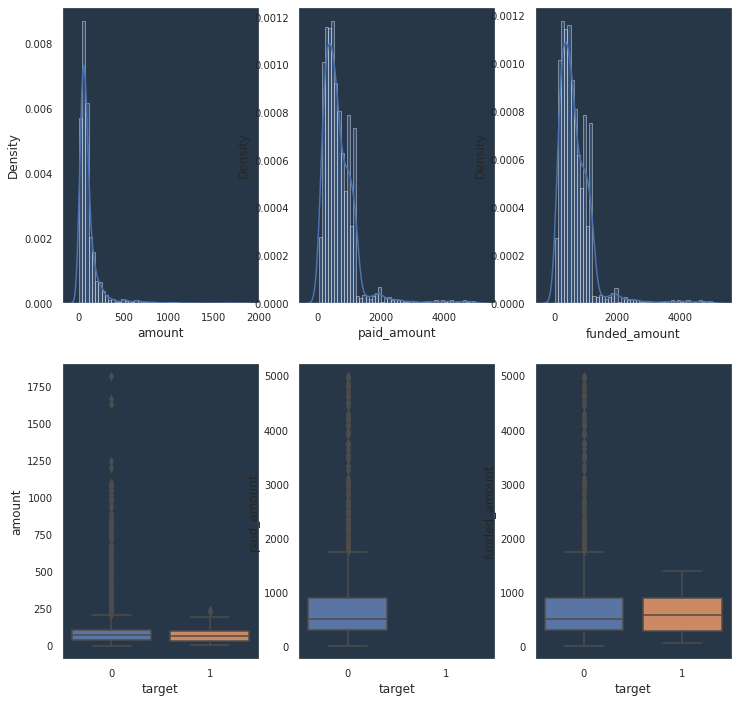

In [50]:
numerical_cols1 = ['amount','paid_amount','funded_amount']
plt.figure(figsize=(12,12))

i=1
for col in numerical_cols1:
    plt.subplot(2,3,i)
    sns.distplot(data[col])
    plt.subplot(2,3,3+i)
    sns.boxplot(y=data[col], x = data['target'])
    i+=1

In [51]:
# Remplacement des données 95% percetile value
Q4 = data['paid_amount'].quantile(0.90) # Get 95th quantile
print("Le nombre total de paid_amount est de : ",len(data[data['paid_amount'] >= Q4]))
data.loc[data['paid_amount'] >= Q4, 'paid_amount'] = Q4 # outlier capping

Q4 = data['funded_amount'].quantile(0.90) # Get 95th quantile
print("Le nombre total de funded_amount est de :",len(data[data['funded_amount'] >= Q4]))
data.loc[data['funded_amount'] >= Q4, 'funded_amount'] = Q4 # outlier capping

Le nombre total de paid_amount est de :  357
Le nombre total de funded_amount est de : 370


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


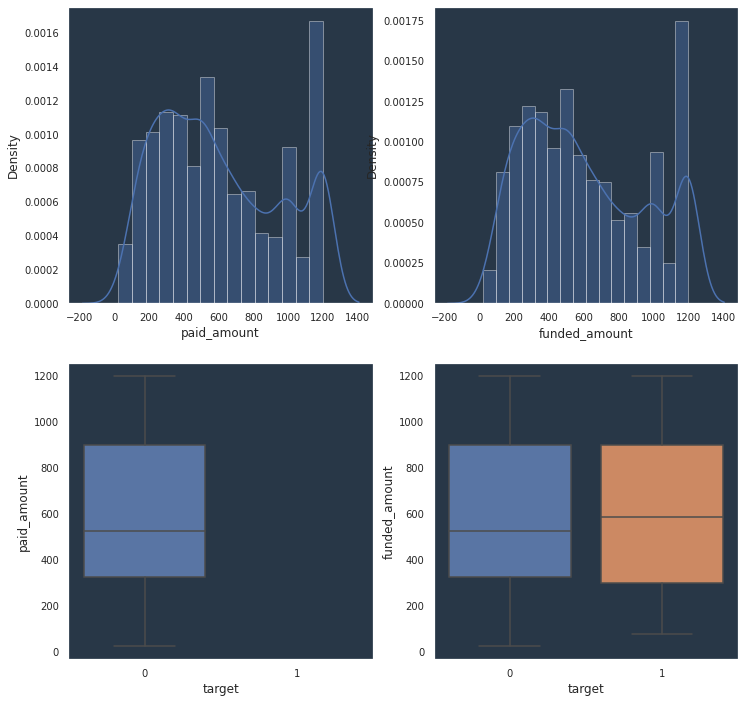

In [52]:
numerical_cols1 = ['paid_amount', 'funded_amount']
plt.figure(figsize=(12,12))

i=1
for col in numerical_cols1:
    plt.subplot(2,2,i)
    sns.distplot(data[col])
    plt.subplot(2,2,2+i)
    sns.boxplot(y=data[col], x = data['target'])
    i+=1

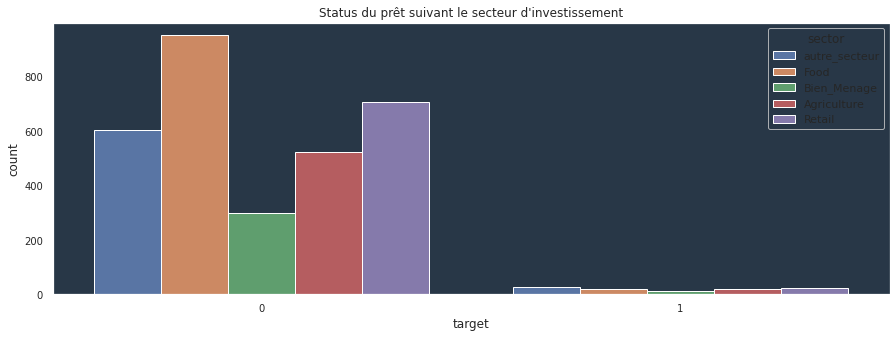

In [53]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x="target", hue='sector', data=data).set_title("Status du prêt suivant le secteur d'investissement");

#### - Categorials variables
The aim of this session is to sump up the univariate analysis in term of doing some basics modifications in our previous variables like recode, define a label and so one.

In [54]:
data.sector.value_counts()

Food             970
Retail           727
autre_secteur    632
Agriculture      540
Bien_Menage      312
Name: sector, dtype: int64

In [55]:
data.columns

Index(['id', 'status', 'funded_amount', 'paid_amount', 'sector',
       'country_name', 'gender', 'borrower_pictured', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'basket_amount', 'amount', 'payment_id', 'local_amount',
       'processed_date', 'rounded_local_amount', 'settlement_date', 'lat',
       'lon', 'target', 'CONTINENT'],
      dtype='object')

In [56]:
categorical_var = ['gender','borrower_pictured','terms.loss_liability.nonpayment']
data[categorical_var] = data[categorical_var].astype('category')
data['gender'] = data['gender'].cat.codes
data['borrower_pictured'] = data['borrower_pictured'].cat.codes
data['terms.loss_liability.nonpayment'] = data['terms.loss_liability.nonpayment'].cat.codes

In [57]:
# We can group the sector variable
others = ['Manufecturing', 'Health', 'Housing', 'Wholesale', 'Personal Use', 'Education', 'Entertainment']
data['sector_cat'] = np.where(data['sector'].isin(others), "Other", data['sector'])

In [58]:
#We can create dummy variables
data = pd.get_dummies(data, columns=['sector_cat','CONTINENT','terms.loss_liability.currency_exchange'], prefix = ['sector','continent','currency_exchange'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181 entries, 0 to 5002
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 3181 non-null   object 
 1   status                             3181 non-null   object 
 2   funded_amount                      3181 non-null   float32
 3   paid_amount                        3081 non-null   float32
 4   sector                             3181 non-null   object 
 5   country_name                       3181 non-null   object 
 6   gender                             3181 non-null   int8   
 7   borrower_pictured                  3181 non-null   int8   
 8   terms.disbursal_amount             3181 non-null   object 
 9   terms.disbursal_currency           3181 non-null   object 
 10  terms.disbursal_date               3181 non-null   int64  
 11  terms.loan_amount                  3181 non-null   float

In [59]:
# Converting amount data
amount_var = ['terms.disbursal_amount','terms.local_payments.amount','terms.scheduled_payments.amount','local_amount','rounded_local_amount']
for var in amount_var :
  data[var] = np.where(data[var].isna(),0.0,data[var])
  data[var]=data[var].str.replace(',', '.')
data[amount_var] = data[amount_var].astype('float')

In [60]:
date_var = ['terms.disbursal_date','paid_date','defaulted_date','terms.local_payments.due_date','terms.scheduled_payments.due_date','processed_date']
data = data.drop(['id','status','terms.disbursal_currency','country_name','sector','delinquent', 'terms.scheduled_payments.amount','rounded_local_amount', 'basket_amount', 'sector_Agriculture', 'continent_Africa','currency_exchange_none'], axis=1)
data = data.drop(date_var, axis=1)
data

,funded_amount,paid_amount,gender,borrower_pictured,terms.disbursal_amount,terms.loan_amount,terms.loss_liability.nonpayment,posted_date,funded_date,journal_totals.entries,terms.local_payments.amount,amount,payment_id,local_amount,settlement_date,lat,lon,target,sector_Bien_Menage,sector_Food,sector_Retail,sector_autre_secteur,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,currency_exchange_partner,currency_exchange_shared
0,500.0,500.0,1,0,500.0,500.0,1,2006,2005,1.0,NaN,50.00,209.0,50.00,2006.0,12.150833,-86.268333,0,0,0,0,1,0,0,1,0,0,0,0
1,600.0,NaN,1,0,600.0,600.0,0,2006,2005,7.0,NaN,50.00,261.0,50.00,NaN,31.284167,34.250833,1,0,0,0,1,1,0,0,0,0,0,0
2,500.0,500.0,0,0,500.0,500.0,1,2006,2005,2.0,NaN,35.00,200.0,35.00,2006.0,14.600000,-87.833333,0,0,1,0,0,0,0,1,0,0,0,0
3,500.0,500.0,0,0,500.0,500.0,1,2006,2005,2.0,NaN,35.00,189.0,35.00,NaN,14.600000,-87.833333,0,0,0,0,1,0,0,1,0,0,0,0
4,575.0,575.0,0,0,575.0,575.0,1,2006,2005,2.0,NaN,114.00,435.0,114.00,2007.0,-0.866667,36.433333,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,150.0,150.0,0,0,7000.0,150.0,1,2009,2009,2.0,368.42,7.89,35990841.0,368.42,2009.0,13.000000,122.000000,0,0,0,1,0,1,0,0,0,0,1,0
4997,350.0,350.0,0,0,50000.0,350.0,1,2009,2009,1.0,6250.00,43.75,44587807.0,6250.00,2009.0,6.583333,3.750000,0,0,1,0,0,0,0,0,0,0,1,0
5000,225.0,225.0,0,0,10000.0,225.0,1,2009,2009,2.0,192.31,28.12,36020263.0,1250.00,2009.0,13.000000,122.000000,0,0,0,0,0,1,0,0,0,0,1,0
5001,75.0,75.0,0,0,3000.0,75.0,1,2009,2009,2.0,120.00,12.05,36020291.0,482.17,2009.0,13.000000,122.000000,0,1,0,0,0,1,0,0,0,0,1,0


> Missing value treatment : with this caption, we have the quick look in the distribution of the missing values in our final dataset.

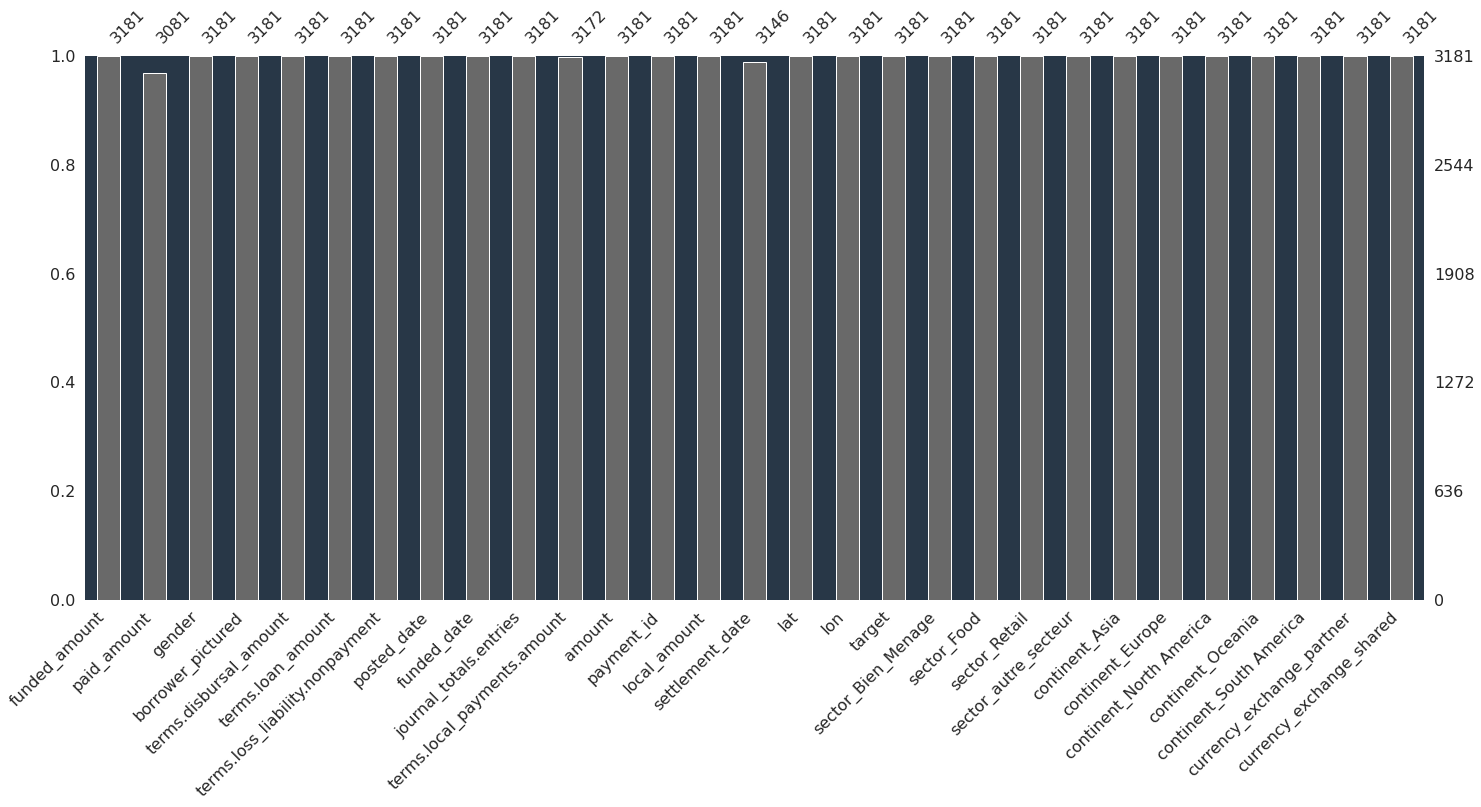

In [61]:
msno.bar(data)

In [69]:
# Imputation of the variable which already contain missing values.
imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(data)
imputed = pd.DataFrame(imputed)
imputed.columns = data.columns
data = imputed

# Modelisation
The main target of this session is to use the previous result to build our prediction model. Due to the imbalance of our dataset, we will use some specifics algorithms like **SMOTE** and **Near Miss Algorithm**. We will compare the perfomance both of them to have the best imbalance algorithm for our models. So, we will start for building our imbalance algorithms, and then build our selection model for having the perfomance of our predictions models.
Before starting, we have to sleep our data set into train and test set. The test set, will be use after building the predictions models to evaluate their performance. 


In [62]:
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Probit
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

logit = LogisticRegression()

In [71]:
# split into 70:30 ration 
Y = data['target']
X = data.drop(['target'], axis=1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)
print("Before OverSampling, counts of label '1': {}".format(sum(Y_train == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(Y_train == 0))) 
print("test set counts of label '1': {}".format(sum(Y_test == 1))) 
print("test set counts of label '0': {}".format(sum(Y_test == 0)))

Before OverSampling, counts of label '1': 68
Before OverSampling, counts of label '0': 2158
test set counts of label '1': 32
test set counts of label '0': 923


### **Imbalance algorithms**

##### 1) SMOTE (Synthetic Minority Oversampling Technique)
This algorithm aims to balance class distribution by randomly increasing minority class examples by replicating them. *SMOTE* generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [ ]:
!pip install imblearn
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NearMiss 

In [72]:
sm = SMOTE(random_state = 2) 
X_train_sm, y_train_sm = sm.fit_sample(X_train, Y_train.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [73]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_sm.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_sm.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_sm == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_sm == 0))) 

After OverSampling, the shape of train_X: (4316, 28)
After OverSampling, the shape of train_y: (4316,) 

After OverSampling, counts of label '1': 2158
After OverSampling, counts of label '0': 2158


##### 2) NearMiss Algorithm
aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, we remove the instances of the majority class to increase the spaces between the two classes. This helps in the classification process.
To prevent problem of information loss in most under-sampling techniques, near-neighbor methods are widely used.

In [78]:
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, Y_train.ravel()) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [79]:
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

After Undersampling, the shape of train_X: (136, 28)
After Undersampling, the shape of train_y: (136,) 

After Undersampling, counts of label '1': 68
After Undersampling, counts of label '0': 68
